In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/dacon_temperatue")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 온도 추정 AI 경진대회

## Library & Data

In [ ]:
import sys
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline 

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# mutiprocessing
from multiprocessing.dummy import Pool as ThreadPool

In [ ]:
# ML algorithms
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error

### Data

In [ ]:
# Load datasets
sample_submission = pd.read_csv("./sample_submission.csv")
train = pd.read_csv("./train.csv", index_col='id')
test = pd.read_csv("./test.csv", index_col='id')

In [ ]:
# 시간순으로 정렬된 10분 단위 데이터
train

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.00,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.00,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.00,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.00,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.00,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.00,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.00,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.00,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.00,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.00,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,19.9,987.6,0.9,0.8,0.0,1006.9,987.7,21.7,1007.5,1007.4,2.5,23.88,95.3,333.1,0.0,274.9,0.0,275.5,0.9,0.0,89.7,10.5,1000.4,1007.5,0.0,0.0,1.2,1006.0,23.8,999.4,89.9,17.7,19.1,1007.5,22.16,218.6,0.0,82.3,58.6,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,19.9,987.6,0.5,0.7,0.0,1006.8,987.7,21.6,1007.5,1007.4,2.5,23.88,95.6,216.4,0.0,277.3,0.0,247.0,1.0,0.0,90.1,10.5,1000.3,1007.5,0.0,0.0,1.3,1006.0,23.6,999.4,91.3,17.7,19.2,1007.5,22.16,161.7,0.0,82.5,59.1,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,19.7,987.7,0.9,0.6,0.0,1006.9,987.6,21.4,1007.4,1007.5,2.5,23.88,95.9,127.8,0.0,256.1,0.0,299.1,0.6,0.0,90.8,10.5,1000.4,1007.6,0.0,0.0,0.2,1006.0,23.6,999.5,90.2,17.8,19.2,1007.5,22.16,254.2,0.0,83.0,58.9,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [ ]:
# indicator dictionary
indicator_dict = {
    'temperature' : ["X00", "X07", "X28", "X31", "X32"],
    'localpressure' : ["X01", "X06", "X22", "X27", "X29"],
    'windspeed'     : ["X02","X03","X18","X24","X26"], 
    'precipitation' : ["X04","X10","X21","X36","X39"], 
    'atmpressure'   : ["X05","X08","X09","X23","X33"], 
    'insolation'    : ["X11","X34","X14","X16","X19"], 
    'humidity'      : ["X12","X20","X30","X37","X38"], 
    'winddirection' : ["X13","X15","X17","X25","X35"], 
}

In [ ]:
# split the train dataset into the one with Y01-Y17 and one with Y18
train1 = train[train["Y18"].isnull()].copy()
train2 = train[~train["Y18"].isnull()].copy()

train1_X = train1.iloc[:, :40] # X00 ~ X39
train1_Ys = train1.iloc[:, 40:-1] # Y0 ~ Y17

train2_X = train2.iloc[:, :40]
train2_Y18 = train2.iloc[:, -1]

In [ ]:
test_X = test.copy()

combined_X = pd.concat([train1_X, train2_X, test_X], axis=0)
X_list = [train1_X, train2_X, test_X]

## Data Cleansing and Pre-processing

In [ ]:
# missing values
print(combined_X.isnull().sum().sum())
print(train1_Ys.isnull().sum().sum())
print(train2_Y18.isnull().sum())

0
0
0


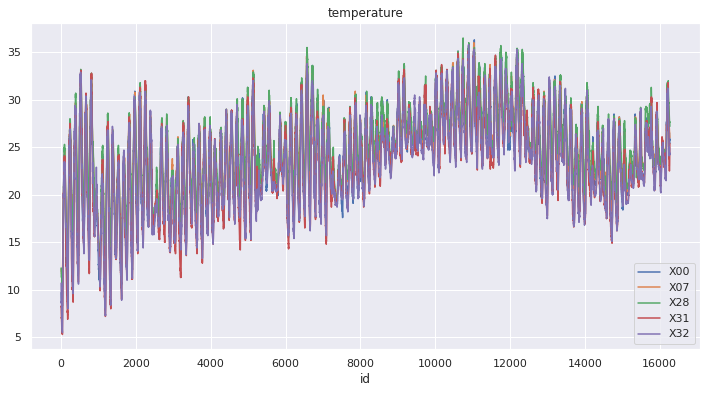

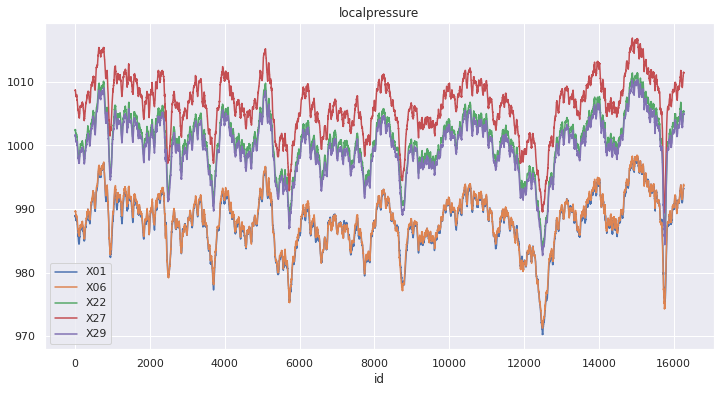

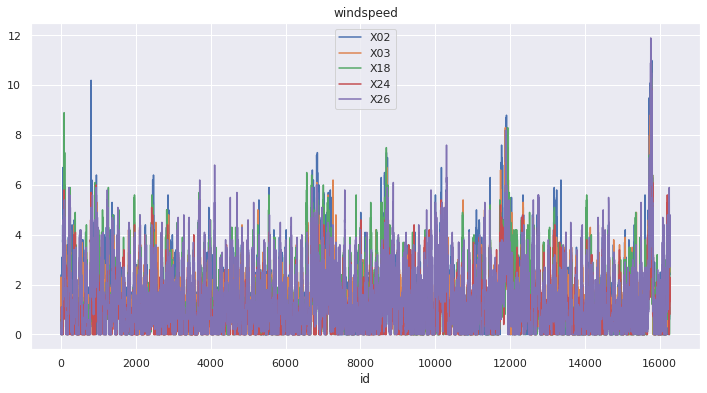

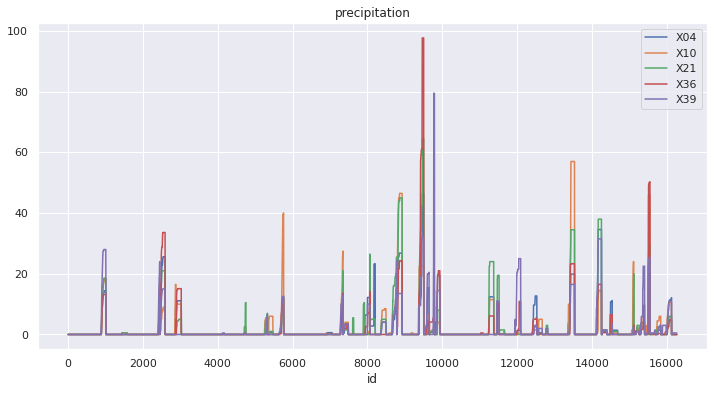

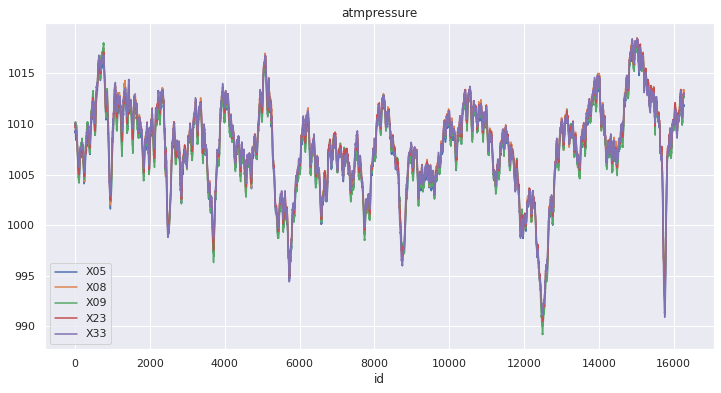

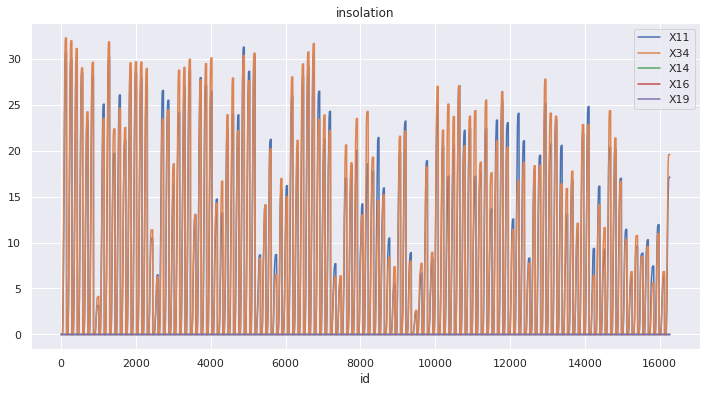

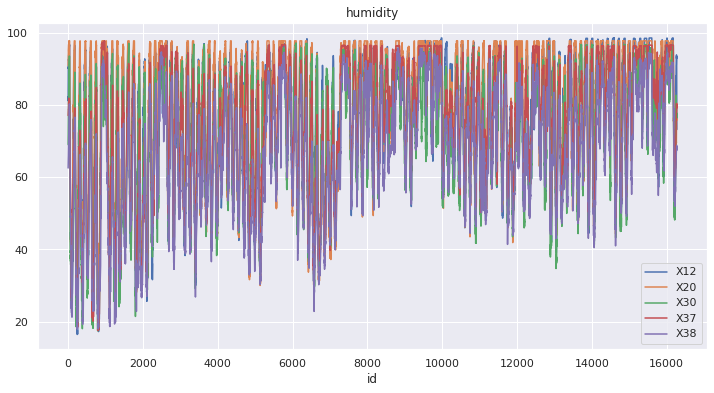

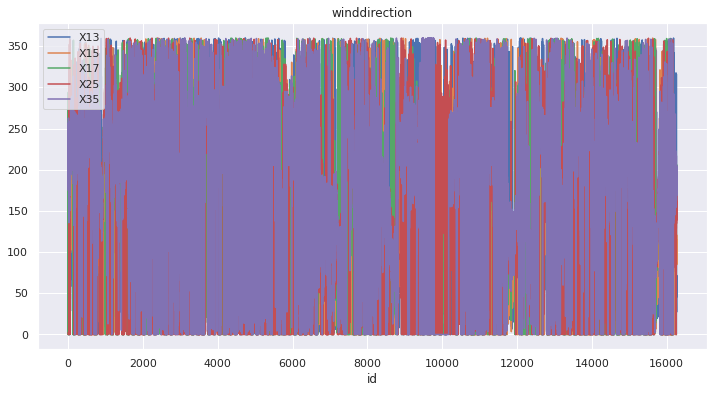

In [ ]:
# anomalies
for key, values in indicator_dict.items():
    combined_X.reset_index().plot(x='id', y=values, figsize=(12, 6))
    plt.gca().set_title(key)

In [ ]:
combined_X[['X14', 'X16', 'X19']].sum()

X14    0.0
X16    0.0
X19    0.0
dtype: float64

In [ ]:
# drop X14, X16, X19
for X in X_list + [combined_X]:
    X.drop(['X14', 'X16', 'X19'], axis=1, inplace=True)

indicator_dict['insolation'] = ['X11', 'X34']

In [ ]:
# create day an time variable
for X in X_list + [combined_X]:
    X['day'] = X.index // 144
    X['time'] = X.index % 144

In [ ]:
# insolation and precipitation modification
# both are cumulative values

# insolation, get hourly difference
for X in X_list:
    days = X['day'].unique()
    for d in days:
        day_idx = X.loc[X['day'] == d].index
        for f in indicator_dict['insolation']:
            X.loc[day_idx, f] = X.loc[day_idx, f] - X.loc[day_idx, f].shift(periods=6).fillna(0)

In [ ]:
# for precipitation get 6 hours difference
for X in X_list:
    days = X['day'].unique()
    for f in indicator_dict['precipitation']:
        for d in days[::-1]:
            day_idx = combined_X.loc[combined_X['day'] == d].index
            yes_day_idx = combined_X.loc[(combined_X['day'] == d-1)].index
            day_precip = combined_X.loc[(yes_day_idx | day_idx), f]

            # first day cumulative precipitation value set to 0
            yesterday_cum_precip = day_precip.loc[yes_day_idx].max() if d!=0 else 0
            day_precip.loc[day_idx] += yesterday_cum_precip
            day_precip_shift = day_precip.shift(periods=36).fillna(0)

            X.loc[day_idx, f] = day_precip.loc[day_idx] - day_precip_shift.loc[day_idx]

## EDA and Feature generation

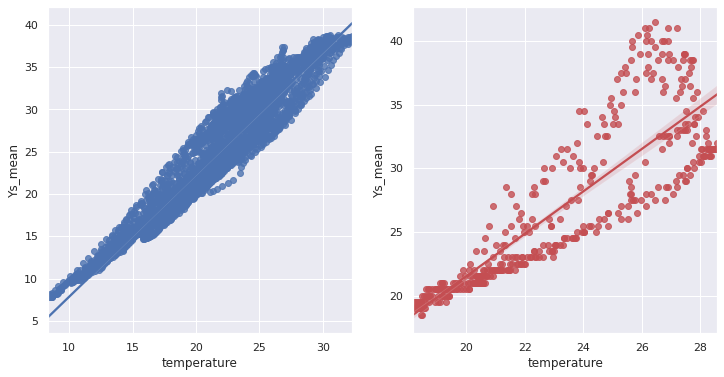

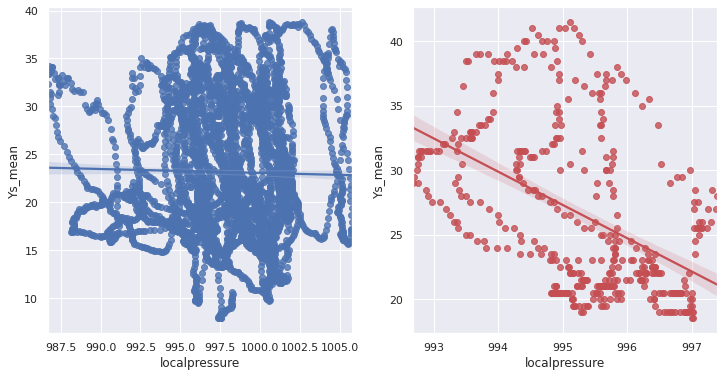

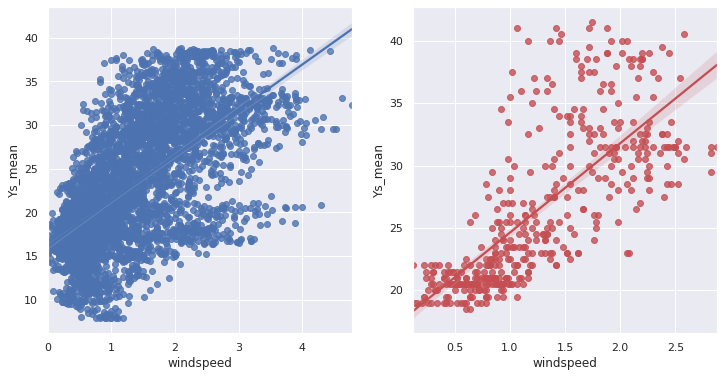

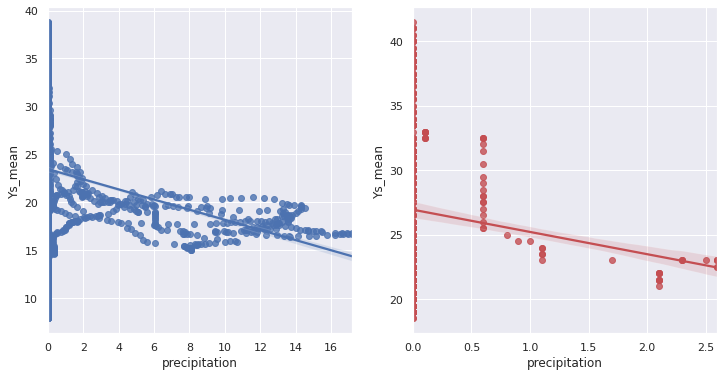

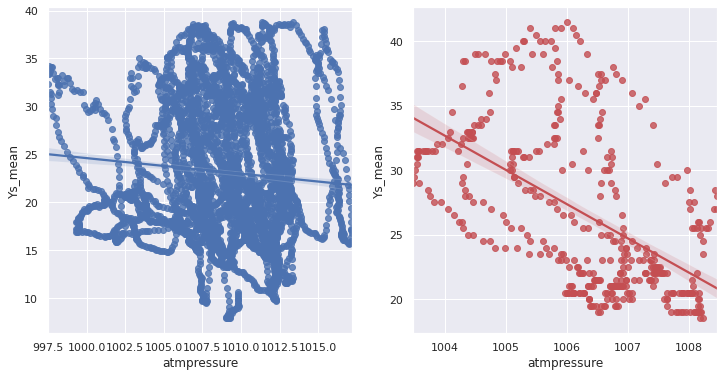

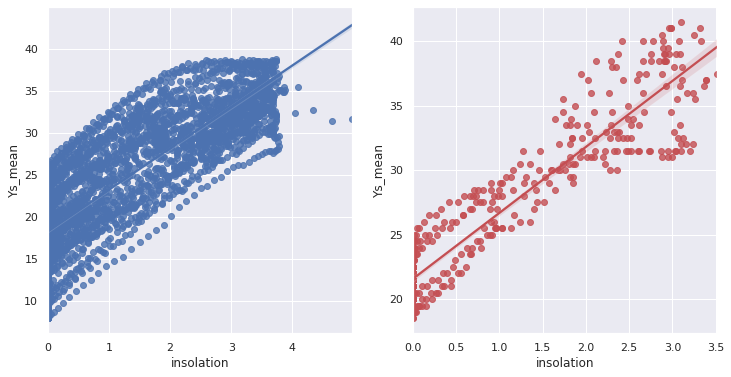

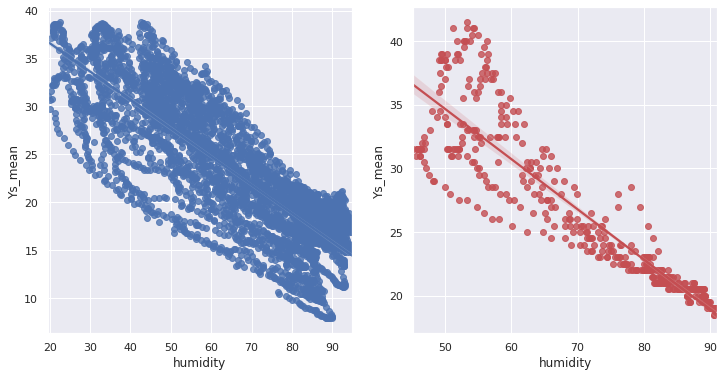

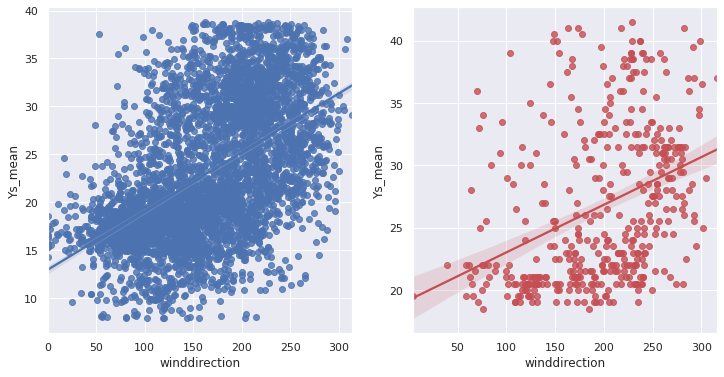

In [ ]:
# 각 feature 그룹과 Y 값들의 correlation 시각화
train1_Ys_mean = train1_Ys.mean(axis=1)
for key, values in indicator_dict.items():
    train1_feature_mean = train1_X[values].mean(axis=1)
    train2_feature_mean = train2_X[values].mean(axis=1)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.regplot(train1_feature_mean, train1_Ys_mean, ax=ax[0])
    sns.regplot(train2_feature_mean, train2_Y18, ax=ax[1], color='r')
    ax[0].set_xlabel(key)
    ax[0].set_ylabel('Ys_mean')
    ax[1].set_xlabel(key)
    ax[1].set_ylabel('Ys_mean')

In [ ]:
# keep only temperature, humidity, insolation

for df in X_list:
    df.drop(indicator_dict['localpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['atmpressure'], axis=1, inplace=True)
    df.drop(indicator_dict['windspeed'], axis=1, inplace=True)
    df.drop(indicator_dict['winddirection'], axis=1, inplace=True)
    df.drop(indicator_dict['precipitation'], axis=1, inplace=True)

indicator_dict = dict((k,indicator_dict[k]) for k in ['temperature', 'humidity', 'insolation'] if k in indicator_dict)

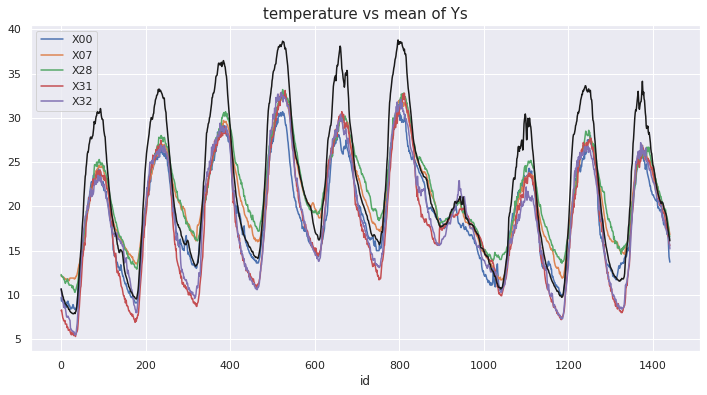

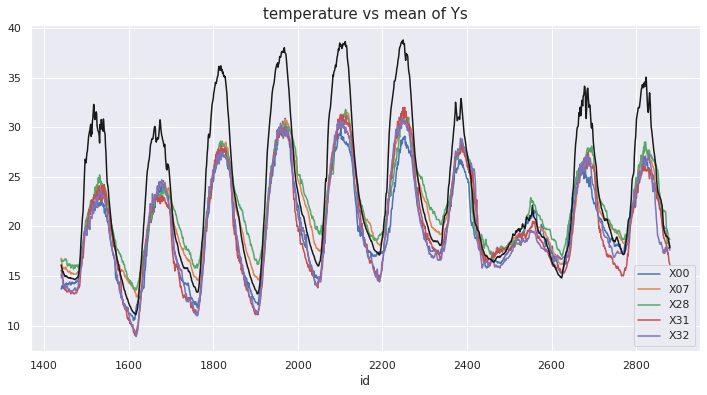

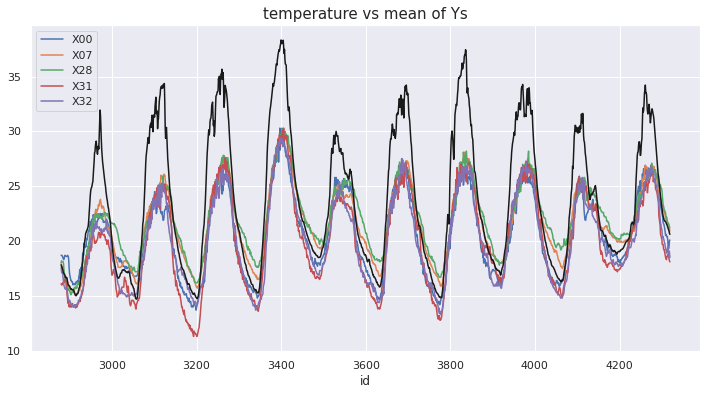

In [ ]:
# feature variation analysis
# get daily visualization
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['temperature']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('temperature vs mean of Ys', size=15)

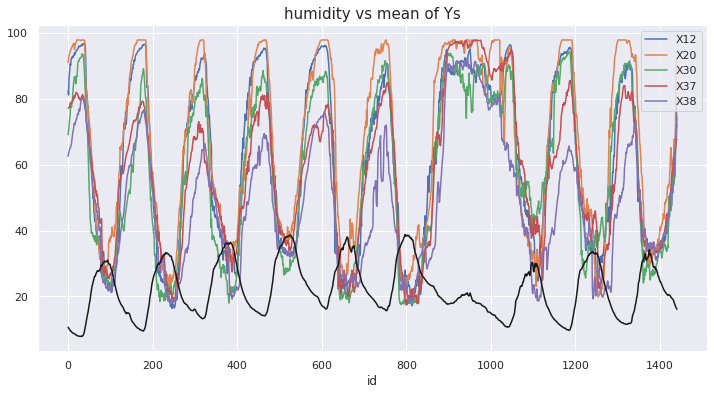

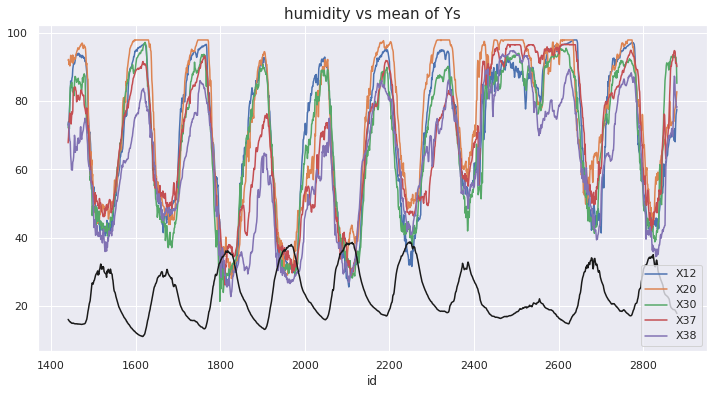

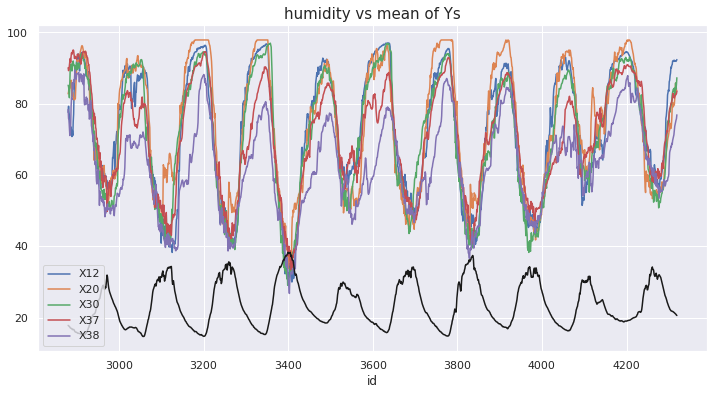

In [ ]:
# humidity
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['humidity']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('humidity vs mean of Ys', size=15)

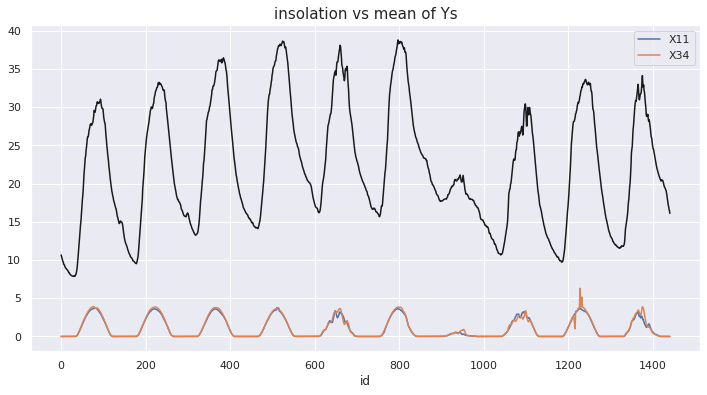

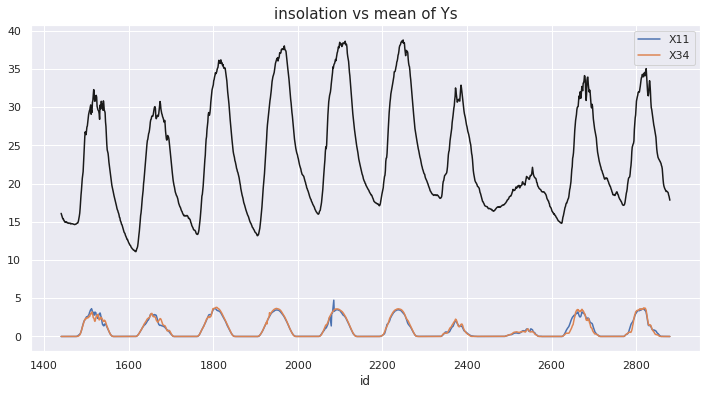

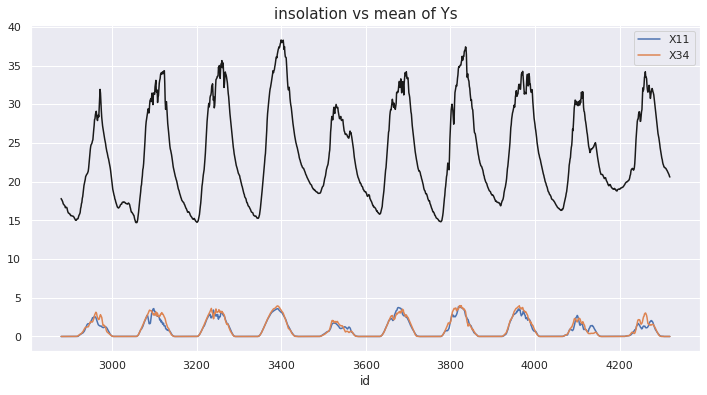

In [ ]:
# insolation
for idx in range(0, 30, 10):
    idx1, idx2 = 144*idx, 144*(idx+10)

    fig, ax = plt.subplots(figsize=(12, 6))
    train1_X.loc[idx1:idx2, indicator_dict['insolation']].plot(ax=ax)
    train1_Ys_mean.loc[idx1:idx2].plot(ax=ax, color='k')
    ax.set_title('insolation vs mean of Ys', size=15)

In [ ]:
# generate temp_mean and hum_mean for use
for X in X_list:
    X['temp_mean'] = X[["X07", "X28", "X31", "X32"]].mean(1)
    X['hum_mean'] = X[["X30", "X37", "X38"]].mean(1)
indicator_dict['temperature'].append('temp_mean')
indicator_dict['humidity'].append('hum_mean')

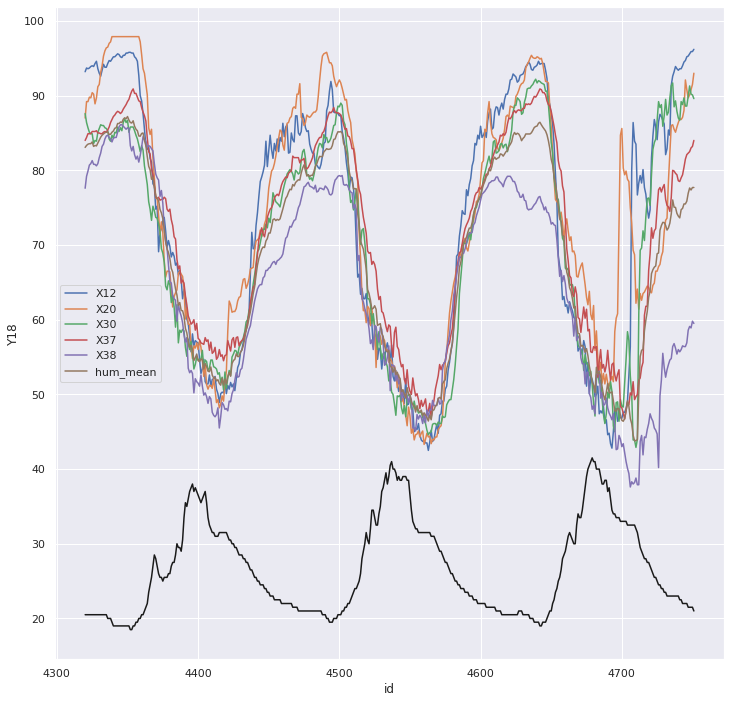

In [ ]:
## visualize train2 features and Y18
# humidity
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x=train2_X.index, y=train2_Y18, ax=ax, c='k')
train2_X[indicator_dict['humidity']].plot(ax=ax)


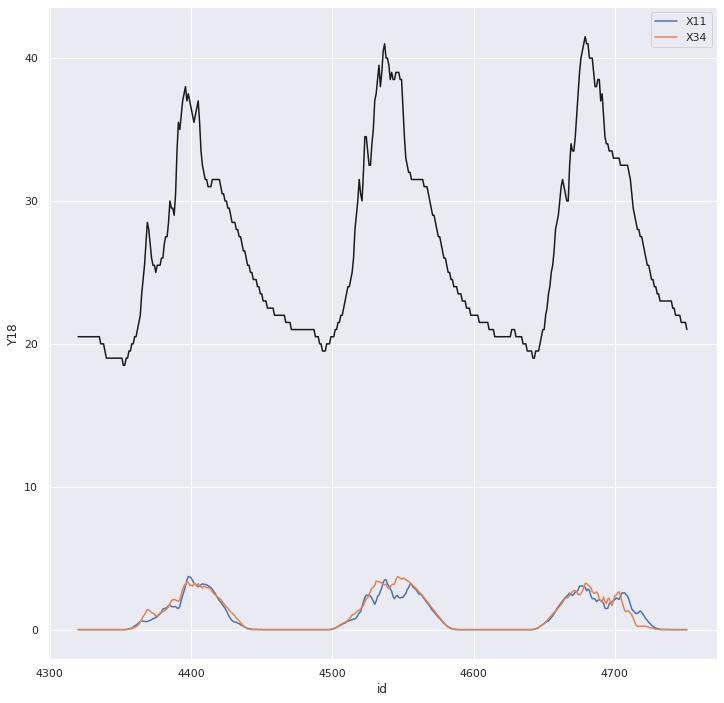

In [ ]:
# insolation
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x=train2_X.index, y=train2_Y18, ax=ax, c='k')
train2_X[indicator_dict['insolation']].plot(ax=ax)

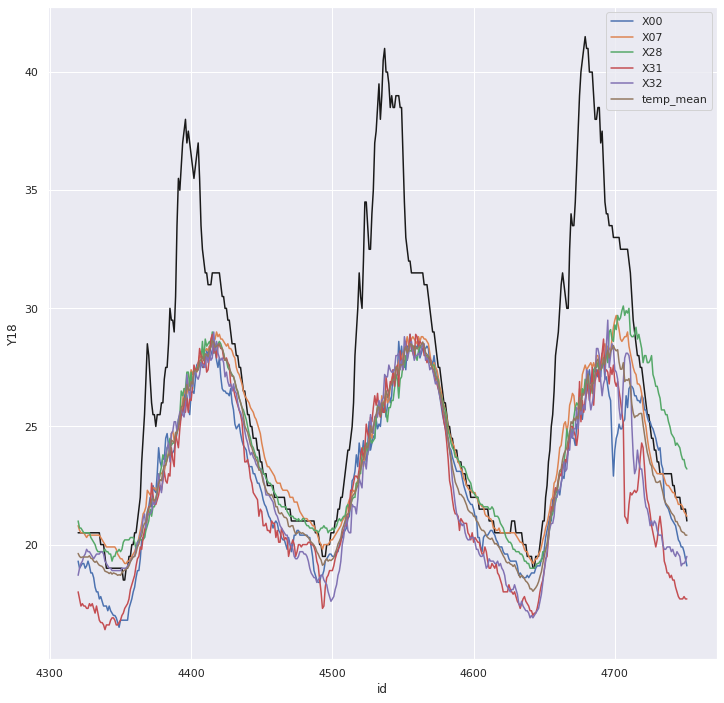

In [ ]:
# temperature
fig, ax = plt.subplots(figsize=(12, 12))
sns.lineplot(x=train2_X.index, y=train2_Y18, ax=ax, c='k')
train2_X[indicator_dict['temperature']].plot(ax=ax)

In [ ]:
# as Y18 decrease rapidly after highest temp, create shadow variable to take account
for X in X_list:
    insol = X['X34']
    insol.index = X.index
    neg_insol = pd.Series(np.zeros_like(insol.values), index=X.index)

    time1_index = X.loc[X['time'] == 80].index # shadow start
    time2_index = X.loc[X['time'] == 89].index # shadow end
    end_index = X.loc[X['time'] == 143].index

    for t1, t2, end in zip(time1_index, time2_index, end_index):
        neg_insol.loc[t1:t2-1] = insol.loc[t1:t2-1] * (np.logspace(-1, 0, (t2-t1))-0.1)
        neg_insol.loc[t2:end] = insol.loc[t2:end]
    
    # multiply mean humidity as it will offset shadow effect
    humidity_mean = X[indicator_dict['humidity']].mean(1) / 100
    X['neg_insol'] = neg_insol * (1-humidity_mean)
    
indicator_dict['insolation'].append('neg_insol')

